In [1]:
import os
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.linalg as la

In [2]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools

In [3]:
def get_slice(filename):
    'Reads from dicom file basic information and returns image as array + aquisition time'
    ds = pydicom.dcmread(filename)
    image_2d = ds.pixel_array.astype(float)
    return image_2d, np.float(ds.AcquisitionTime)

In [4]:
def get_t2(path, nr_slices = 29, time_steps = 7):
    '''
    Gets T2 weighted image and its acquisition times.
    IN:
        path - path with T2 weighted images
        nr_slices - nr of slices in image
        time_steps - nr of echo times per slice
    OUT:
        matrix - with T2 weighted images in numpy array (nr_slices, time_steps, width, heigth)
        time_lists - list of aquisition times
    '''
    slices = []
    time_slices = []
    for slice_idx in range(1, nr_slices+1): # iterates over all slices
        temp_slice = []
        time_slice = []
        for i in range(time_steps): # iterates over all time steps
            file_path = dirname + '%03d' % (i * nr_slices + slice_idx)
            image, aq_time = get_slice(file_path)
            temp_slice.append(image)
            time_slice.append(aq_time)
        temp_slice = np.array(temp_slice)
        time_slices.append(time_slice)
        slices.append(temp_slice)
    slices = np.array(slices)

    vmax = np.max(slices)
    # Rescaling grey scale between 0-255
    slices = (np.maximum(slices,0) / vmax) * 255.0
    slices = np.float32(slices) #uint8
    return slices, time_slices

test without int

In [5]:
def registration_between_timesteps(image_matrix):
    '''
    Performs registration between each 2 time points of an image slice.
    IN:
        image_matrix - matrix with T2 weighted images (slices, time steps, width, heigth)
    OUT:
        image_reg_matrix - matrix of the same size as image_matrix
    '''
    metric = CCMetric(2)
    level_iters = [200, 100, 50, 25]
    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)
    
    image_reg_matrix = np.zeros(image_matrix.shape)
    
    for i_sl in range(image_matrix.shape[0]):
        image_reg_matrix[i_sl, 0, :, :] = image_matrix[i_sl, 0, :, :]
        for i_t in range(image_matrix.shape[1]-1):
            mapping = sdr.optimize(image_matrix[i_sl, i_t, :, :], image_matrix[i_sl, i_t+1, :, :])
            image_reg_matrix[i_sl, i_t+1, :, :] = mapping.transform(image_matrix[i_sl, i_t+1, :, :])
    return image_reg_matrix

In [6]:
from scipy.io import loadmat
#get_t2_binary_mask
segmentation = []
for i in range(29):
    mat = loadmat("data/9003126/T2BinarySegmentation/9003126_4_{}.mat".format(i))
    segmentation.append(mat['femoral_cartilage'])
    if np.all(mat['femoral_cartilage']==0):
        print(i)
segmentation = np.array(segmentation)

0
1
2
3
4
24
25
26
27
28


In [7]:
dirname = "data/9003126/T2/"

In [76]:
t2imgs, t2times = get_t2(dirname)

In [478]:
slice_idx = 20
scan = t2imgs[slice_idx,:,:,:]
mri_time = np.array(t2times[slice_idx]) - t2times[slice_idx][0]
segmentation_mask = segmentation[slice_idx,:,:]

In [479]:
data = np.log(scan + 0.0000000001) # to avoid log(0)

In [480]:
x = np.concatenate((np.ones_like(mri_time[..., np.newaxis]), -mri_time[..., np.newaxis]), 1)

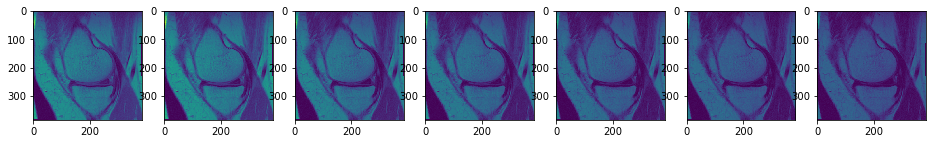

In [481]:
plt.figure(figsize=(16,8))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(scan[i,:,:], vmin=0, vmax=255)

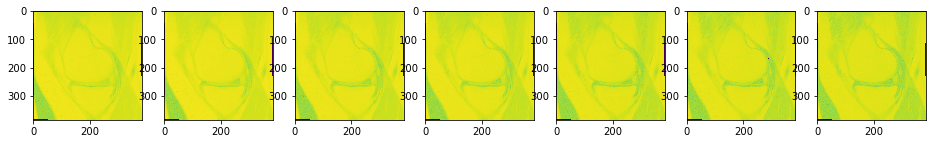

In [482]:
plt.figure(figsize=(16,8))
for i in range(7):
    plt.subplot(1,7,i+1)

    plt.imshow(data[i,:,:], vmin=np.min(data), vmax=np.max(data))

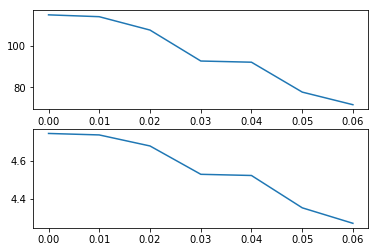

In [483]:
plt.subplot(211)
plt.plot(mri_time, scan[:,200,100])
plt.subplot(212)
plt.plot(mri_time, data[:,200,100])

In [508]:
t2_matrix = np.zeros((data.shape[1], data.shape[2]))
res_matrix = np.zeros((data.shape[1], data.shape[2]))
s0_matrix = np.zeros((data.shape[1], data.shape[2]))
exps = []
for ix in range(data.shape[2]):
    for iy in range(data.shape[2]):
        if all(data[:,ix,iy] == data[0,ix,iy]): # if constant value, decay 0 
            t2_matrix[ix, iy] = 0
            res_matrix[ix, iy] = 0
            continue
        beta, res, _, _ = la.lstsq(x[1:], data[1:,ix,iy])
        exps.append(data[:,ix,iy])
        s0_ = beta[0]
        s0_matrix[ix, iy] = s0_
        t2_ = 1./beta[1] # in ms
        t2_matrix[ix, iy] = t2_
        res_matrix[ix, iy] = res

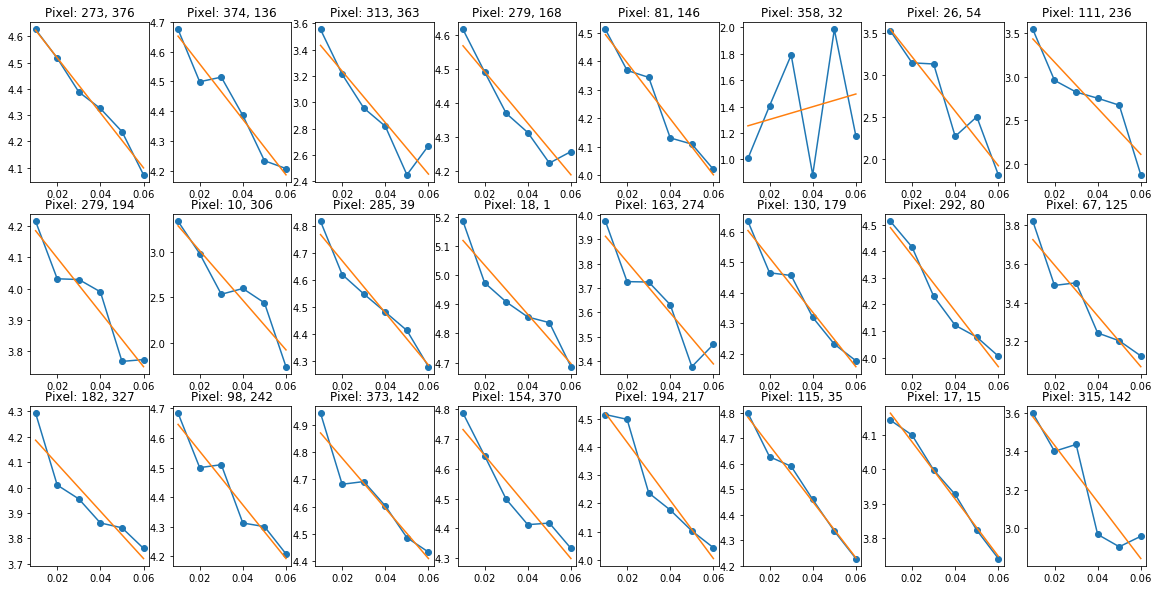

In [509]:
plt.figure(figsize=(20,10))
for i in range(24):
    plt.subplot(3,8,i+1)
    ix, iy = int(np.random.uniform()*s0_matrix.shape[0]), int(np.random.uniform()*s0_matrix.shape[0])
    plt.plot(mri_time[1:],data[1:,ix, iy], 'o-')
    plt.plot(mri_time[1:], s0_matrix[ix, iy] - mri_time[1:]/t2_matrix[ix, iy])
    plt.title('Pixel: {}, {}'.format(ix, iy))

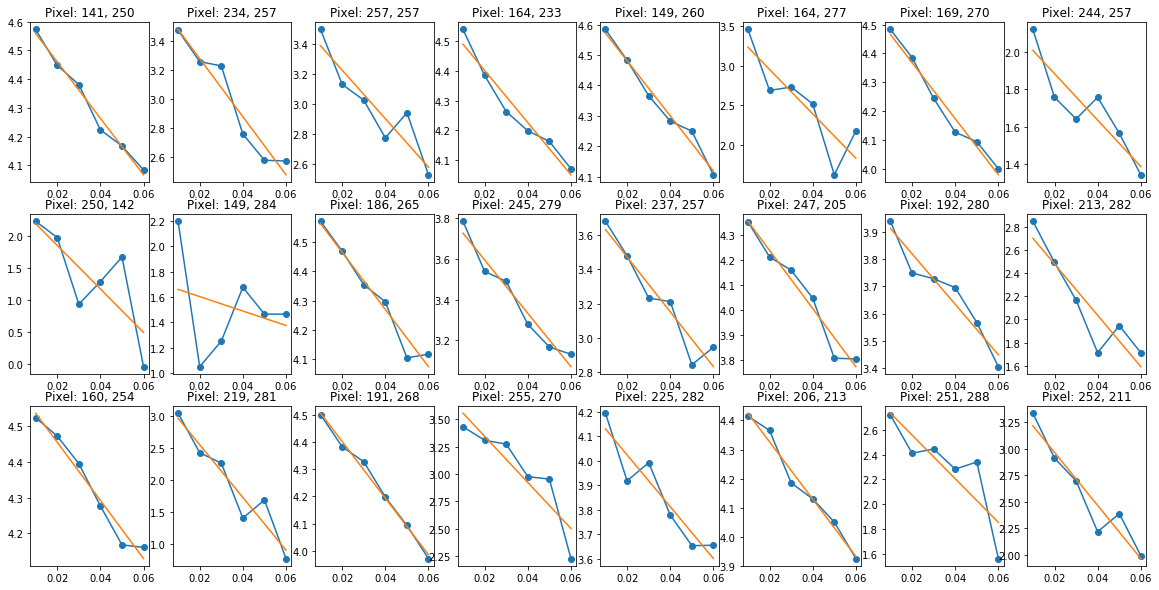

In [510]:
mask_idxs = np.where(segmentation_mask == 1)
plt.figure(figsize=(20,10))
for i in range(24):
    plt.subplot(3,8,i+1)
    ix, iy = mask_idxs[0][int(np.random.uniform()*len(mask_idxs[0]))], mask_idxs[1][int(np.random.uniform()*len(mask_idxs[0]))]
    plt.plot(mri_time[1:],data[1:,ix, iy], 'o-')
    plt.plot(mri_time[1:], s0_matrix[ix, iy] - mri_time[1:]/t2_matrix[ix, iy])
    plt.title('Pixel: {}, {}'.format(ix, iy))

In [511]:
# Non-linear curve fit

#from scipy.optimize import curve_fit
#def model_func(x, a, k):
#    return a * np.exp(-k*x)
#t2_nl_matrix = np.zeros((scan.shape[1], scan.shape[2]))
#for ix in range(scan.shape[2]):
#    for iy in range(scan.shape[2]):
#        if all(scan[:,ix,iy] == scan[0,ix,iy]): # if constant value, decay 0 
#            t2_nl_matrix[ix, iy] = 0
#            continue
#        p0 = (1., 0.1)
#        opt, pcov = curve_fit(model_func, time[1:], scan[1:,ix,iy], p0)
#        a, k = opt
#        t2_nl_matrix[ix, iy] = 1./k

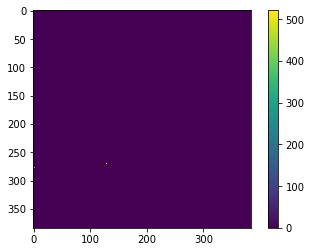

In [512]:
plt.imshow(res_matrix)
plt.colorbar()

In [513]:
res_matrix[np.where(res_matrix > np.percentile(res_matrix.flatten(), 98.))]=0
res_matrix[np.where(res_matrix < 0)] = 0

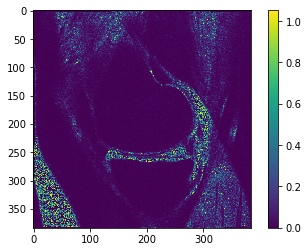

In [514]:
plt.imshow(res_matrix)
plt.colorbar()

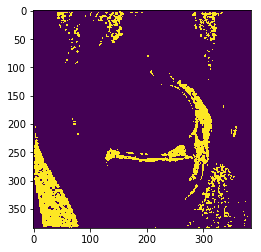

In [515]:
from skimage.filters import gaussian
noise_mask = gaussian(res_matrix, sigma=1) > 0.2
plt.imshow(noise_mask)

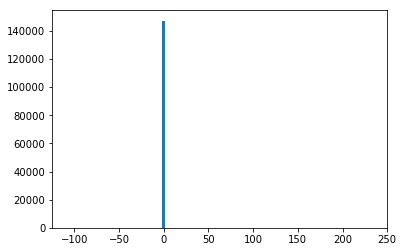

In [516]:
plt.hist(t2_matrix.flatten(),bins=100)
plt.show()

In [517]:
t2_matrix[np.where(t2_matrix > np.percentile(t2_matrix.flatten(), 98))] = 0
#t2_matrix[np.where(t2_matrix > 0.4)] = 0.4
t2_matrix[np.where(t2_matrix < 0)] = 0

In [497]:
t2_matrix[np.where(res_matrix > 0.1)] = 0

In [498]:
#t2_matrix = np.ma.masked_outside(t2_matrix,0,0.4)

In [499]:
#t2_matrix[np.where(segmentation_mask != 1)] = 0

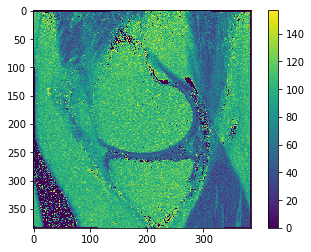

In [518]:
plt.imshow(t2_matrix*1000)
plt.colorbar()

In [412]:
np.mean(t2_matrix[np.where(t2_matrix > 0)]*1000)

57.820853747924566

In [414]:
np.mean([51.24, 56.9866, 56.8367, 58.1049, 61.40921, 64.93073, 69.662003, 56.85799, 52.91442, 55.507, 61.376669, 61.861282, 57.63225, 67.860276, 59.7371424, 58.02321, 60.493119, 61.56934, 57.8208537])

59.51703658421053

In [521]:
t2_matrix_cart = np.copy(t2_matrix)

In [522]:
t2_matrix_cart[np.where(segmentation_mask != 1)] = 0

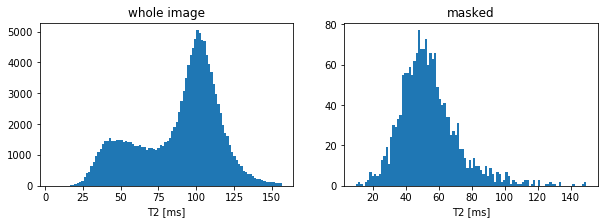

In [532]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(t2_matrix[np.where(t2_matrix>0)]*1000,bins=100)
plt.xlabel('T2 [ms]')
plt.title('whole image')
plt.subplot(122)
plt.hist(t2_matrix_cart[np.where(t2_matrix_cart>0)]*1000,bins=100)
plt.xlabel('T2 [ms]')
plt.title('masked')
plt.show()

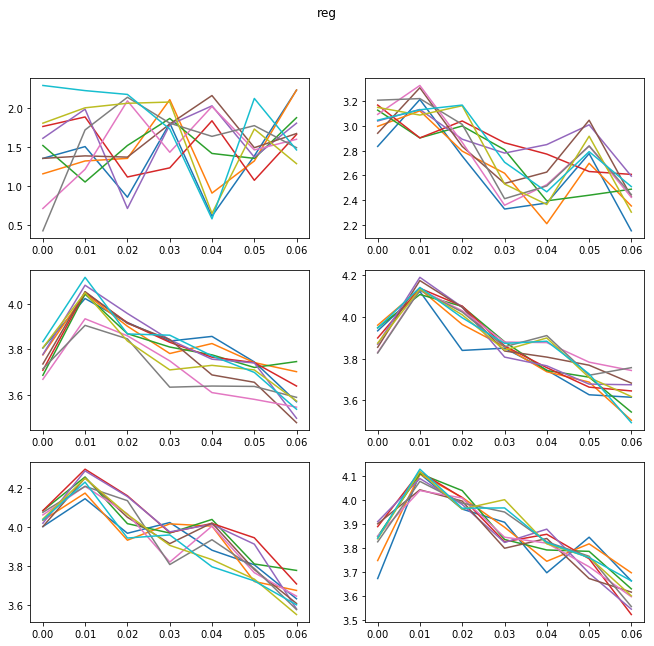

In [475]:
exps = np.array(exps)
plt.figure(figsize=(11,10))
plt.subplot(3,2,1)
plt.plot(mri_time, exps[:10].T,'-')
plt.subplot(3,2,2)
plt.plot(mri_time, exps[20:30].T,'-')
plt.subplot(3,2,3)
plt.plot(mri_time, exps[90:100].T,'-')
plt.subplot(3,2,4)
plt.plot(mri_time, exps[250:260].T,'-')
plt.subplot(3,2,5)
plt.plot(mri_time, exps[300:310].T,'-')
plt.subplot(3,2,6)
plt.plot(mri_time, exps[450:460].T,'-')
plt.suptitle('reg')

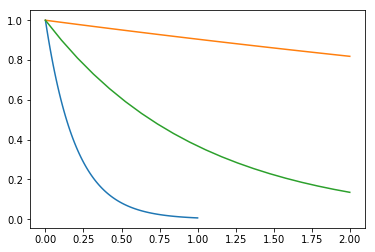

In [33]:
plt.plot(np.linspace(0,1,100), np.exp(-np.linspace(0,1,100)/0.2))
plt.plot(np.linspace(0,2,20), np.exp(-np.linspace(0,2,20)/10))
plt.plot(np.linspace(0,2,20), np.exp(-np.linspace(0,2,20)/1))

# Fit T2 to all slices

In [441]:
import time

In [476]:
t2_tensor = []
t0 = time.time()
for slice_idx in range(t2imgs.shape[0]):
    scan = t2imgs[slice_idx,:,:,:]
    mri_time = np.array(t2times[slice_idx]) - t2times[slice_idx][0]
    segmentation_mask = segmentation[slice_idx,:,:]
    data = np.log(scan + 0.0000000001) # to avoid log(0)
    x = np.concatenate((np.ones_like(mri_time[..., np.newaxis]), -mri_time[..., np.newaxis]), 1)
    t2_matrix = np.zeros((data.shape[1], data.shape[2]))
    res_matrix = np.zeros((data.shape[1], data.shape[2]))
    for ix in range(data.shape[2]):
        for iy in range(data.shape[2]):
            if all(data[:,ix,iy] == data[0,ix,iy]): # if constant value, decay 0 
                t2_matrix[ix, iy] = 0
                res_matrix[ix, iy] = 0
                continue
            beta, res, _, _ = la.lstsq(x[1:], data[1:,ix,iy])
            t2_ = 1./beta[1]
            t2_matrix[ix, iy] = t2_
            res_matrix[ix, iy] = res
    res_matrix[np.where(res_matrix > np.percentile(res_matrix.flatten(), 98.))]=0
    res_matrix[np.where(res_matrix < 0)] = 0
    t2_matrix[np.where(t2_matrix > np.percentile(t2_matrix.flatten(), 97.))] = 0
    #t2_matrix[np.where(t2_matrix > 0.4)] = 0.4
    t2_matrix[np.where(t2_matrix < 0)] = 0
    t2_matrix[np.where(res_matrix > 0.1)] = 0
    #t2_matrix[np.where(segmentation_mask != 1)] = 0
    t2_tensor.append(t2_matrix * 1000) # in ms
t2_tensor = np.array(t2_tensor)
print(time.time() - t0)

735.676181078


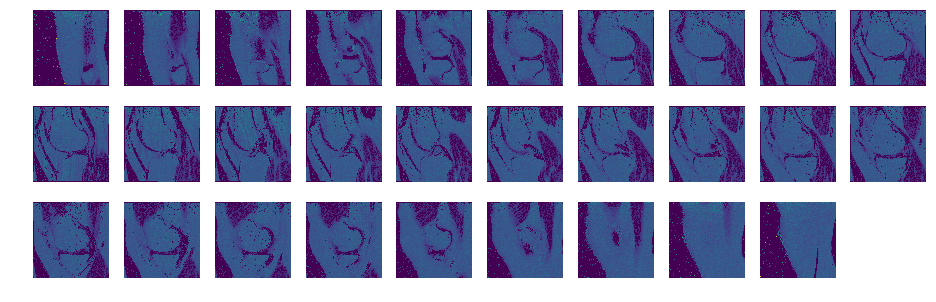

In [477]:
plt.figure(figsize=(16,5))
for i in range(t2_tensor.shape[0]):
    plt.subplot(3,10, i +1)
    plt.imshow(t2_tensor[i], vmin=0, vmax=np.max(t2_tensor))
    plt.axis('off')
    #if i == t2_tensor.shape[0]-1:
    #    plt.colorbar()